In [7]:
from typing import Dict, Union
# from langgraph.graph import StateGraph
from langchain.agents import AgentExecutor, Tool
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
import base64
from typing_extensions import Annotated, List, TypedDict, Dict, Any, Literal
from typing import Optional
# from langgraph.graph.message import add_messages
# from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain.prompts.chat import ChatPromptTemplate
import json
from pydantic import BaseModel, Field


In [8]:
class VlmResponse(BaseModel):
    description : Dict
    product_details : Dict


class RouterResponse(BaseModel):
    tool_usage: Literal["Wiki_tool", "links_tool", "no_tool"] = Field(description="The tool to be used by the LLM based on user's request. It must be one of: 'links_tool' or 'Wiki_tool'")


class State(BaseModel):
    """Simple state object."""
    msg : List[str]
    input_type: Literal["image", "text"]
    content : str
    image_bytes : bytes
    product_info : VlmResponse
    workflow : RouterResponse
    wiki_response : str
    wiki_data : str
    session_id : str



In [ ]:
def input_decide_edge(state: State) -> Literal["image_node", "text_node"]:
    if state.input_type == "image":
        return "image_node"
    elif state.input_type == "text":
        return "text_node"

In [2]:

    
from groq import Groq
from dotenv import load_dotenv
import os
load_dotenv()
api = os.environ['GROQ_API']
client = Groq(api_key=api)
tavily_api=os.environ['TAVILY_API_KEY']



In [ ]:


prompt_info = """
What is the object in this image? Provide a brief description including its key characteristics like the brand, style, quality, and any relevant information from a shopping perspective. The result should be in JSON format where:"
"- The key product should hold the name of the object (e.g., phone), *only the product name, no brand or other descriptors*."
"- Include additional keys for other relevant details such as brand, style, quality, and any other pertinent attributes based on the image."
"- The JSON object should contain these keys in a consistent format, with the values varying based on the image content."

"Example:"
"For a picture which contains a phone, the response should look like this:
{
  "product": "phone",
  "brand": "Brand Name",
  "style": "Smartphone",
  "quality": "High",
  "features": ["Touchscreen", "Fast Charging", "Camera Quality"]
}
Select the parameters of this JSON result according to the image and there is no need to always use the given parameters
Return the result in JSON format. No description or any other content
Dont write anything else. no suggestions
"""

In [ ]:
prompt_description = """
You are a helpful assistant that explains products to people who have no prior knowledge about them.

Your task is to analyze an image of a product and provide a detailed, easy-to-understand explanation of what it is, how it works, what it’s used for, and why someone might need or use it. Break down any visual branding, design features, or common use cases clearly.

Respond in the following JSON format only:

### JSON Output Format:
{
  "product_name": "",
  "category": "",
  "detailed_explanation": "",
  "common_uses": [],
  "who_might_use_this": [],
  "related_products_or_alternatives": []
}

### Example 1:
Image: A black wireless headphone with a Sony logo and cushioned ear cups.
Output:
{
  "product_name": "Sony WH-1000XM5 Wireless Noise Cancelling Headphones",
  "category": "Electronics - Audio",
  "detailed_explanation": "These are over-ear wireless headphones made by Sony, designed to provide high-quality audio without the need for cords. They include noise-cancelling technology to block out background sounds, making them ideal for focus or travel. The cushioned ear cups and adjustable headband offer comfort for long listening sessions.",
  "common_uses": ["Listening to music", "Taking calls", "Watching movies", "Blocking noise while traveling"],
  "who_might_use_this": ["Commuters", "Office workers", "Students", "Music enthusiasts"],
  "related_products_or_alternatives": ["Bose QuietComfort 45", "Apple AirPods Max", "Sennheiser Momentum 4"]
}

### Example 2:
Image: A purple yoga mat with a textured surface and rolled edge.
Output:
{
  "product_name": "Manduka PRO Yoga Mat",
  "category": "Fitness - Yoga Equipment",
  "detailed_explanation": "This is a yoga mat designed to provide a non-slip, cushioned surface for practicing yoga or stretching exercises. It is textured for grip and made of durable material to support regular use. The mat can be rolled up and carried easily, making it portable for home, gym, or studio use.",
  "common_uses": ["Yoga", "Pilates", "Stretching", "Bodyweight exercises"],
  "who_might_use_this": ["Yoga practitioners", "Fitness enthusiasts", "People doing home workouts"],
  "related_products_or_alternatives": ["Liforme Yoga Mat", "Gaiam Essentials Mat", "Lululemon Reversible Mat"]
}

Select the parameters of this JSON result according to the image and there is no need to always use the given parameters
Return the result in JSON format. No description or any other content
Dont write anything else. no suggestions
"""

In [ ]:


ROUTER_PROMPT = """ 
You are an AI converstaional assistant and you are responsible to make descisions on What tool do we need to use to provide the user with the necessary information he needs.
You have to take into account the whole conversation so far to make a decision to determine what would be the best next choice of tool to use.
GENERAL RULES:
1. Always consider the whole conversation before you make a decision.
2. Only return one of these outputs - "Wiki_tool", "links_tool" or "no_tool".

IMPORTANT RULES FOR Wiki_tool calling:
1. only use this tool when user want to know information about the given product.
2. only use this tool when user wants a clarification of a doubt.
3. only use this tool when user is asking a question.
4. DO NOT create use the tool for general questions and descriptions.
5. DO NOT use the tool for general messages and descriptions.
6. There should be an intent of the user to know information about the product or ask any question regarding it. 

IMPORTANT RULES FOR links_tool calling:
1. Only use this tool if there is an explicit request by the user for suggestion of pproducts.
2. Only use this tool if the user wants to buy the products
3. Only use this tool if the user wants to links for the products to buy.
4. There should be an intent of the user to get suggestions or recommendations for similar products.

IMPORTANT RULES FOR no_tool calling:
1. only return no tool if there is no need to call any tool as per the user's intention.
2. do this only if user has sent a general message and doesnt want any information from other tool's capabilities.
3. DO NOT use this if user is asking for any information or questions.
4. DO NOT use this if user is interested to buy the product.
4. only use this for general messages and descriptions from the user.


The output must be one of:
1. 'Wiki_tool' - only when the intent for the user is to get information regarding the product or get clarifications on his questions.
2. 'links_tool' - only when there is an intent of the user to find products to buy or get the links of the products.
3. 'no_tool' - only when there is no need for any other tool and there is a general message sent by the user.
"""

In [ ]:
def handle_image(params: Dict) -> Dict:
    # Here we'd typically do more complex image processing
    image_data_url = f"data:image/jpeg;base64,{base64.b64encode(params['content']).decode()}"
    prompt_template_vision = [
                            {
                                "role": "user",
                                "content": [
                                    {
                                        "type": "text",
                                        "text": params['prompt']
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": {
                                            "url": image_data_url
                                        }
                                    }
                                ]
                            }
                        ]
    completion = client.chat.completions.create(
                            model="meta-llama/llama-4-scout-17b-16e-instruct",
                            messages=prompt_template_vision,
                            temperature=1,
                            max_tokens=1024,
                            top_p=1,
                            stream=False,
                            stop=None,
                        )
    response = completion.choices[0].message.content
    print("Vision resp =",response)
    try:
        return {"result": json.loads(response)}
    except json.JSONDecodeError:
        print("NON JSON RESP")
        return {"result":response}
    

In [ ]:
url = 'D:\Projects\SRM\\testing\\temp_D92760A4-ECB4-49BC-8CB3-025AB6B4DBF4.jpg'
with open(url, "rb") as image_file:
    image_binary = image_file.read()
    # image_bytes = base64.b64encode(image_binary).decode()
    image_result = handle_image({"content": image_binary, 'prompt': prompt_info})
    print(image_result)
    

Vision resp = {
 "product": "t-shirt",
 "brand": "Nike",
 "style": "Graphic T-shirt",
 "quality": "High",
 "features": ["Cotton Material", "Short Sleeve", "Crew Neck"]
}
{'result': {'product': 't-shirt', 'brand': 'Nike', 'style': 'Graphic T-shirt', 'quality': 'High', 'features': ['Cotton Material', 'Short Sleeve', 'Crew Neck']}}


In [17]:
url = 'D:\Projects\SRM\\testing\\temp_D92760A4-ECB4-49BC-8CB3-025AB6B4DBF4.jpg'
with open(url, "rb") as image_file:
    image_binary = image_file.read()
    # image_bytes = base64.b64encode(image_binary).decode()
    image_result = handle_image({"content": image_binary, 'prompt': prompt_description})
    print(image_result)
    

Vision resp = {
 "product_name": "Nike Graphic T-Shirt",
 "category": "Fashion - Apparel",
 "detailed_explanation": "This is a black, short-sleeved T-shirt made by Nike, featuring a graphic print on the front. The print includes a colorful tropical pattern with leaves and flowers, and the Nike logo prominently displayed in white. The shirt appears to be made of comfortable, casual wear material, suitable for everyday use. The design is versatile, allowing it to be dressed up or down depending on the occasion.",
 "common_uses": ["Casual wear", "Athleisure", "Running errands", "Social outings"],
 "who_might_use_this": ["Young adults", "Athletes", "Fashion enthusiasts", "Anyone looking for casual apparel"],
 "related_products_or_alternatives": ["Adidas Graphic T-Shirt", "Under Armour T-Shirt", "Champion Graphic Tee"]
}
{'result': {'product_name': 'Nike Graphic T-Shirt', 'category': 'Fashion - Apparel', 'detailed_explanation': 'This is a black, short-sleeved T-shirt made by Nike, featuring

In [ ]:
def vision_node(state: State):
    prod_info = handle_image({'content':state.image_bytes, 'prompt': prompt_info})
    prod_desc = handle_image({'content':state.image_bytes, 'prompt': prompt_description})
    resp = VlmResponse(description=prod_desc, product_details=prod_info)
    state.product_info = resp
    return state
    

In [ ]:
from langchain_core.prompts import ChatPromptTemplate , MessagesPlaceholder

def get_router_chain():
    model = ChatGroq( api_key=api, model="gemma2-9b-it").with_structured_output(RouterResponse)

    prompt = ChatPromptTemplate.from_messages(
        [("system", ROUTER_PROMPT), MessagesPlaceholder(variable_name="messages")]
    )

    return prompt | model



In [15]:
chain = get_router_chain()



In [ ]:
chain.invoke({'messages': ["give me some product links like this"]}).tool_usage


'links_tool'

In [95]:
chain.invoke({'messages': ["can i wear this in summer"]}).tool_usage


'Wiki_tool'

In [96]:
chain.invoke({'messages': ["i want to buy this"]}).tool_usage


'links_tool'

In [97]:
chain.invoke({'messages': ["give me more info on this product"]}).tool_usage


'Wiki_tool'

In [106]:
a = chain.invoke({'messages': ["what is it used for?"]}).tool_usage

b = chain.invoke({'messages': ["this product is a tshirt", "what is it used for?"]}).tool_usage

a,b

('Wiki_tool', 'Wiki_tool')

In [102]:
chain.invoke({'messages': ["how to use this"]}).tool_usage


'no_tool'

In [103]:
chain.invoke({'messages': ["hello"]}).tool_usage


'no_tool'

In [20]:
chain.invoke({'messages': ["Does it have hook or zip?"]}).tool_usage


'no_tool'

In [ ]:
# def route_node(state: State):
def router_node(state: State) -> State:
        try:
            chain = get_router_chain()

            state.workflow = chain.invoke({'messages': state.msg[-1:]})
            return state
        except Exception as e:
                raise(e)

In [22]:
def get_llm():
    llm = ChatGroq(api_key=api, model="gemma2-9b-it")
    return llm
 

In [ ]:
fallback_response = "NOT FOUND"
context = '''{
 "product_name": "Nike Graphic T-Shirt",
 "category": "Fashion - Apparel",
 "detailed_explanation": "This is a black, short-sleeved T-shirt made by Nike, featuring a graphic print on the front. The print includes a colorful tropical pattern with leaves and flowers, and the Nike logo prominently displayed in white. The shirt appears to be made of comfortable, casual wear material, suitable for everyday use. The design is versatile, allowing it to be dressed up or down depending on the occasion.",
 "common_uses": ["Casual wear", "Athleisure", "Running errands", "Social outings"],
 "who_might_use_this": ["Young adults", "Athletes", "Fashion enthusiasts", "Anyone looking for casual apparel"],
 "related_products_or_alternatives": ["Adidas Graphic T-Shirt", "Under Armour T-Shirt", "Champion Graphic Tee"]
}'''
system_prompt_wiki = (
        "You are an assistant that only answers questions strictly using the provided context. "
        f"If the answer is not clearly stated or implied in the context, respond exactly with: \"{fallback_response}\""
    )




In [47]:
def context_node(state: State) -> State:
    llm = get_llm()
    user_prompt = (
            f"### CONTEXT ###\n{state.product_info.description}\n\n"
            f"### QUESTION ###\n{state.msg[-1:]}\n\n"
            "Answer the question using only the context above. Also format the answer in a good short sentence"
        )

    messages = [
        {"role": "system", "content": system_prompt_wiki},
        {"role": "user", "content": user_prompt}
    ]

    
    response = llm.invoke(messages)
    state.wiki_response = response
    return state
    


In [ ]:

response=context_node(question = "tell me some alternatives for the nike tshirt")
print(response.content)

Alternatives include Adidas Graphic T-Shirt, Under Armour T-Shirt, and Champion Graphic Tee.



In [ ]:

response=context_node(question = "can this be used in the winters")
print(response.content)

NOT FOUND 



In [ ]:

response=context_node(question = "how to wear it")
print(response.content)

The shirt can be dressed up or down depending on the occasion. 



In [17]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

def wiki_node(state: State) -> State:
    wiki_wrappper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=2000)
    wiki_tool = WikipediaQueryRun(api_wrapper= wiki_wrappper)
    query = f"{state.product_info.product_details['product']}" 

    res = wiki_tool.invoke(query)
    state.wiki_data = res
    return state


In [ ]:

wiki_node("T-Shirt")

"Page: T-shirt\nSummary: A T-shirt (also spelled tee shirt, or tee for short) is a style of fabric shirt named after the T shape of its body and sleeves. Traditionally, it has short sleeves and a round neckline, known as a crew neck, which lacks a collar. T-shirts are generally made of stretchy, light, and inexpensive fabric and are easy to clean. The T-shirt evolved from undergarments used in the 19th century and, in the mid-20th century, transitioned from undergarments to general-use casual clothing. \nT-shirts are typically made of cotton textile in a stockinette or jersey knit, which has a distinctively pliable texture compared to shirts made of woven cloth. Some modern versions have a body made from a continuously knitted tube, produced on a circular knitting machine, such that the torso has no side seams. The manufacture of T-shirts has become highly automated and may include cutting fabric with a laser or a water jet.\nT-shirts are inexpensive to produce and are often part of fa

In [11]:
WIKI_CHATBOT_SYSTEM_PROMPT = '''You are a helpful and intelligent assistant trained to infer answers using reasoning and indirect hints from the given context.

You will be provided with:
1. A user question
2. Product-specific information (may or may not be directly helpful)
3. General context (like a Wikipedia article or summary)

The answer is not directly present in the provided information. You are expected to:
- Carefully read the context and try to guess the answer
- Use logical deduction, common sense, and your general knowledge
- If uncertain, make a best-guess based on available clues

Do not say "I don't know" or "It's not mentioned." Instead, provide a thoughtful, inferred answer.
'''

In [ ]:
# def wiki_chatbot_node(state: State) -> State:
def wiki_chatbot_node(question, info, general):

    llm = get_llm()
    user_prompt = (
            # f"### PRODUCT INFORMATION ###\n{state.product_info.description}\n\n"
            # f"### GENERAL INFORMATION ###\n{state.wiki_data}\n\n"
            # f"### QUESTION ###\n{state.msg[-1:]}\n\n"
            f"### PRODUCT INFORMATION ###\n{info}\n\n"
            f"### GENERAL INFORMATION ###\n{general}\n\n"
            f"### QUESTION ###\n{question}\n\n"
            
        )

    messages = [
        {"role": "system", "content": WIKI_CHATBOT_SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt}
    ]

    
    response = llm.invoke(messages)
    # state.wiki_response = response
    # return state
    return response

In [23]:
info = '''{
 "product_name": "Nike Graphic T-Shirt",
 "category": "Fashion - Apparel",
 "detailed_explanation": "This is a black, short-sleeved T-shirt made by Nike, featuring a graphic print on the front. The print includes a colorful tropical pattern with leaves and flowers, and the Nike logo prominently displayed in white. The shirt appears to be made of comfortable, casual wear material, suitable for everyday use. The design is versatile, allowing it to be dressed up or down depending on the occasion.",
 "common_uses": ["Casual wear", "Athleisure", "Running errands", "Social outings"],
 "who_might_use_this": ["Young adults", "Athletes", "Fashion enthusiasts", "Anyone looking for casual apparel"],
 "related_products_or_alternatives": ["Adidas Graphic T-Shirt", "Under Armour T-Shirt", "Champion Graphic Tee"]
}'''

general = '''"Page: T-shirt\nSummary: A T-shirt (also spelled tee shirt, or tee for short) is a style of fabric shirt named after the T shape of its body and sleeves. Traditionally, it has short sleeves and a round neckline, known as a crew neck, which lacks a collar. T-shirts are generally made of stretchy, light, and inexpensive fabric and are easy to clean. The T-shirt evolved from undergarments used in the 19th century and, in the mid-20th century, transitioned from undergarments to general-use casual clothing. \nT-shirts are typically made of cotton textile in a stockinette or jersey knit, which has a distinctively pliable texture compared to shirts made of woven cloth. Some modern versions have a body made from a continuously knitted tube, produced on a circular knitting machine, such that the torso has no side seams. The manufacture of T-shirts has become highly automated and may include cutting fabric with a laser or a water jet.\nT-shirts are inexpensive to produce and are often part of fast fashion, leading to outsized sales of T-shirts compared to other attire. For example, two billion T-shirts are sold worldwide each year, and the average person in Sweden buys nine T-shirts a year. Production processes vary but can be environmentally intensive and include the environmental impact caused by their materials, such as cotton, which uses large amounts of water and pesticides.\n\nPage: Wet T-shirt contest\nSummary: A wet T-shirt contest is a competition involving exhibitionism, typically featuring young female contestants at a nightclub, bar, or resort. Wet T-shirt contestants generally wear thin white or light-colored T-shirts without bras, bikini tops, or other garments beneath. Water (often ice water) is then sprayed or poured onto the participants' chests, causing their T-shirts to turn translucent and cling to their breasts. The comparatively rarer male equivalent is the wet boxer contest, sometimes held at gay bars.\nContestants may take turns dancing or posing before the au"'''

In [28]:
ans = wiki_chatbot_node(question="can i wear this in winters", info=info, general=general)


In [30]:
ans.content

"While the shirt is described as comfortable casual wear, it's made of light material suitable for warm weather.  It's likely not warm enough to wear comfortably in winter.  \n"

In [ ]:
CHATBOT_SYSTEM_PROMPT = '''
You are a friendly and intelligent Shopping Assistant Chatbot, designed to respond when a user sends a general, casual, or conversational message that is not directly related to product search, product image queries, or product support questions.

RULES: 
1. Engage the user in natural, friendly conversation
2. Answer general or casual questions like “Hey, what can you do?”, “Tell me something interesting”, or “How are you?”
3. Politely mention that they can also explore products by uploading a photo, asking product-related questions, or requesting recommendations
4. if the user greets you, respondf with a helpppful tone and mention that your Name is "Shopping Assistant" and also mention your features.
5. Always make a suggestion stating the feature to uploade an image and find out abouyt that product


Never provide product-specific help, image-based search results, or shopping links directly in this mode.
Instead, focus on keeping the conversation engaging and helpful while nudging them toward your shopping features if appropriate.

if the user asks about the chatbot use the following information to answer the questions;

ABOUT THIS CHATBOT:
Our project introduces an advanced shopping assistant powered by a multi-agent workflow designed to optimize and streamline the shopping journey. This intelligent system leverages cutting-edge artificial intelligence to scan shopping items and retrieve detailed product information, including comprehensive descriptions, pricing comparisons, and relevant specifications. By integrating real-time data from multiple sources, the assistant ensures that users receive the most up-to-date and accurate insights, allowing for well-informed purchasing decisions.

FEATURES OF THE CHATBOT:
Our goal is to develop a smart shopping assistant that leverages AI and machine learning to simplify, inform, and enhance the shopping experience. Traditional shopping often demands extensive research and decision-making. Our assistant addresses these challenges by offering an intuitive, AI-driven platform with the following core features:
Automated Product Scanning
Users can quickly identify products using image recognition or scanned codes, eliminating manual search efforts.
Comprehensive Product Descriptions
The assistant delivers detailed specifications, features, and benefits by aggregating information from multiple sources.
Real-time Price Comparison
It continuously tracks prices across platforms to offer real-time comparisons, deal alerts, and cost-saving suggestions.
Insightful Product Reviews
Using sentiment analysis, the system summarizes reviews, highlighting pros and cons to support informed decisions.
Similar Product Recommendations
Based on preferences and behavior, users receive alternative or complementary product suggestions tailored to their needs and budget.
Direct Purchase Links
The assistant offers one-click access to purchase options from various retailers, streamlining the buying process

Now you need to answer the following user question : 
'''

In [ ]:
# def wiki_chatbot_node(state: State) -> State:
def chatbot_node(question):

    llm = get_llm()
    user_prompt = (
            # f"### PRODUCT INFORMATION ###\n{state.product_info.description}\n\n"
            # f"### GENERAL INFORMATION ###\n{state.wiki_data}\n\n"
            # f"### QUESTION ###\n{state.msg[-1:]}\n\n"
            
            f"### QUESTION ###\n{question}\n\n"
            
        )

    messages = [
        {"role": "system", "content": CHATBOT_SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt}
    ]

    
    response = llm.invoke(messages)
    # state.wiki_response = response
    # return state
    return response

In [48]:
print(chatbot_node("hi").content)

Hello! 👋 I'm Shopping Assistant, here to help you find what you're looking for.  

I can answer your questions, tell you interesting facts, or even give you ideas for products you might like. 

If you have a specific item in mind, you can upload a photo or ask me about it.  

What can I do for you today? 😊  




In [49]:
print(chatbot_node("what can you do").content)


Hey there! I'm Shopping Assistant, and I'm here to make your shopping experience a breeze. 

I can help you find all sorts of things by answering your questions, giving you interesting facts, or even suggesting products based on what you're looking for.  

Want to know more about a specific item? You can always ask me about it, or even upload a picture if you have one!  

What can I do for you today? 😊 




In [50]:
print(chatbot_node("i want to do shopping").content)


That's great! I'm here to help make your shopping experience easier and more enjoyable. 

Would you like to tell me what you're looking for? Or maybe you have a picture of something you'd like to find? I can also give you recommendations based on your interests if you'd like. 

Just let me know how I can assist you! 😊  




In [22]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults

def scraping_node_tav(inp):             
    tav_tool = TavilySearchResults(max_results=10)
    search = DuckDuckGoSearchResults()

    search.invoke("Obama")
    query = f"{inp} amazon flipkart official website" 
    res = tav_tool.invoke(query)
    
    return res

In [ ]:
scraping_node_tav("nike tshirt")

[{'url': 'https://www.amazon.in/nike-t-shirts-for-men/b?ie=UTF8&node=13678346031',
  'content': 'Missing: flipkart website'},
 {'url': 'https://www.flipkart.com/clothing-and-accessories/topwear/tshirts/nike~brand/pr?sid=clo%2Cash%2Cank',
  'content': 'NIKE. Dri-FIT Men Printed V Neck Polyester White T-Shirt. 1,995. ₹1,197. 40% off. NIKE. Men Printed Round Neck Pure Cotton White T-Shirt. 1,795. ₹1,436. 20% off.'},
 {'url': 'https://www.nike.com/in/w/mens-sale-tops-t-shirts-3yaepz9om13znik1',
  'content': 'Missing: amazon flipkart'},
 {'url': 'https://www.flipkart.com/mens-tshirts/nike~brand/pr?sid=clo%2Cash%2Cank%2Cedy',
  'content': 'There is a wide range of Nike T-shirts men can choose from, for a combination of comfort and style. You can choose any design and colour as per your preference.'},
 {'url': 'https://www.flipkart.com/nike-india-jersey-printed-men-polo-neck-blue-t-shirt/p/itmfd3g5hke3zekj?pid=TSHFD3G5GNAZY2CV&cmpid=product.share.pp&_refId=PP.bc49203a-c39c-45ba-b16c-9a07cbc59

In [3]:
from langchain_community.tools import DuckDuckGoSearchResults



def scraping_node_duck(inp):             
    search = DuckDuckGoSearchResults()

    query = f"{inp} amazon flipkart official website" 
    res = search.invoke(query)
    
    return res

In [4]:
duck =scraping_node_duck("nike tshirt")

In [5]:
duck

"snippet: Nike Tshirts - Buy Nike Tshirts at India's Best Online Shopping Store. Check Price in India and Shop Online. ✔ Free Shipping ✔ Cash on Delivery ✔ Best Offers - Free Home Delivery & Cash on Delivery at Flipkart.com, title: Nike Tshirts - Buy Nike Tshirts @Upto 40%Off Online at Best ... - Flipkart, link: https://www.flipkart.com/men/tshirts/nike~brand/pr?sid=2oq,s9b,j9y&page=1, snippet: Shop for electronics, apparels & more using our Flipkart app Free shipping & COD. Tshirts - Shop Tshirts at India's Best Online Shopping Store. Check Price and Buy Online. Free Shipping Cash on Delivery Best Offers ... More. Cart. Textured Shirts, Tees... Min. 60% Off + Extra 15% Off. Filters. CATEGORIES. Clothing and Accessories. Topwear. T ..., title: Buy Tshirts Online at Best Prices In India - Flipkart.com, link: https://www.flipkart.com/clothing-and-accessories/topwear/tshirts/pr?sid=clo,ash,ank&q=nike+shirt+for+men, snippet: If yes, then they are authentic. Flipkart/Myntra/Ajio are officia

In [7]:
import re


# Extracting details using regex
entries = re.split(r'(?=snippet:)', duck)

results = []

for entry in entries:
    snippet_match = re.search(r'snippet:\s*(.*?)(?=,\s*title:)', entry, re.DOTALL)
    title_match = re.search(r'title:\s*(.*?)(?=,\s*link:)', entry, re.DOTALL)
    link_match = re.search(r'link:\s*(https?://\S+)', entry, re.DOTALL)

    if snippet_match and title_match and link_match:
        results.append({
            "snippet": snippet_match.group(1).strip(),
            "title": title_match.group(1).strip(),
            "link": link_match.group(1).strip()
        })

# Display the cleaned and structured data
for i, result in enumerate(results, 1):
    print(f"Result {i}:")
    print(f"Title: {result['title']}")
    print(f"Snippet: {result['snippet']}")
    print(f"Link: {result['link']}\n")

Result 1:
Title: Nike Tshirts - Buy Nike Tshirts @Upto 40%Off Online at Best ... - Flipkart
Snippet: Nike Tshirts - Buy Nike Tshirts at India's Best Online Shopping Store. Check Price in India and Shop Online. ✔ Free Shipping ✔ Cash on Delivery ✔ Best Offers - Free Home Delivery & Cash on Delivery at Flipkart.com
Link: https://www.flipkart.com/men/tshirts/nike~brand/pr?sid=2oq,s9b,j9y&page=1,

Result 2:
Title: Buy Tshirts Online at Best Prices In India - Flipkart.com
Snippet: Shop for electronics, apparels & more using our Flipkart app Free shipping & COD. Tshirts - Shop Tshirts at India's Best Online Shopping Store. Check Price and Buy Online. Free Shipping Cash on Delivery Best Offers ... More. Cart. Textured Shirts, Tees... Min. 60% Off + Extra 15% Off. Filters. CATEGORIES. Clothing and Accessories. Topwear. T ...
Link: https://www.flipkart.com/clothing-and-accessories/topwear/tshirts/pr?sid=clo,ash,ank&q=nike+shirt+for+men,

Result 3:
Title: Are these items on Flipkart legit? : r/I

In [1]:
!pip install langgraph


In [10]:
from langgraph.graph import StateGraph, START, END

def injection_node():
    pass

def message_to_memory():
    pass

def vision_node():
    pass

def router_node():
    pass
def context_node():
    pass
def wiki_chatbot_node():
    pass
def chatbot_node():
    pass
def scraping_node_tav():
    pass

def wiki_node():
    pass

def input_decide_edge(self, state: State) -> Literal["vision_node", "injection_node"]:

    pass
def workflow_edge(self, state: State) -> Literal["context_node", "scraping_node_tav", "chatbot_node"]:
    pass
def context_decide_edge(self, state: State) -> Literal["wiki_node", "message_to_memory"]:
    pass

def wiki_decide_edge(self, state: State) -> Literal["wiki_chatbot_node", "message_to_memory"]:
    pass
graph_builder = StateGraph(State)

graph_builder.add_node("vision_node", vision_node)
graph_builder.add_node("injection_node", injection_node)
graph_builder.add_node("router_node", router_node)
graph_builder.add_node("context_node", context_node)
graph_builder.add_node("wiki_node", wiki_node)
graph_builder.add_node("wiki_chatbot_node", wiki_chatbot_node)
graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("scraping_node_tav", scraping_node_tav)
graph_builder.add_node("message_to_memory", message_to_memory)


# Add edges
graph_builder.add_conditional_edges(START, input_decide_edge)
graph_builder.add_edge("vision_node","router_node")
graph_builder.add_edge("injection_node", "router_node")
graph_builder.add_conditional_edges("router_node", workflow_edge)
graph_builder.add_conditional_edges("context_node", context_decide_edge)
graph_builder.add_conditional_edges("wiki_node", wiki_decide_edge)
graph_builder.add_edge("wiki_chatbot_node", "message_to_memory")
graph_builder.add_edge("message_to_memory", END)

graph = graph_builder.compile()

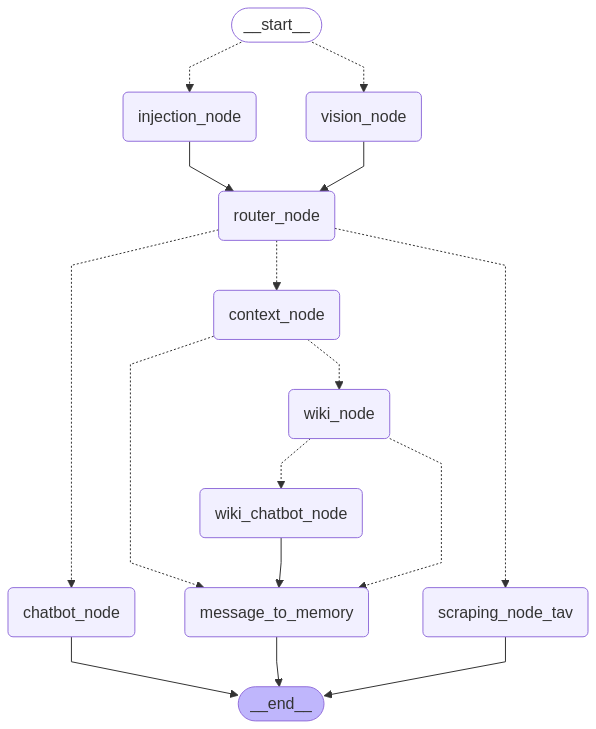

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass